In [223]:
# Imports
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    HNSW,
    RankProfile,
    Component,
    Parameter,
    FieldSet,
    GlobalPhaseRanking,
    Function,
    OnnxModel,
    SecondPhaseRanking
)

from tqdm import tqdm

In [224]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "fgv-pcd251"
# Replace with your application name (does not need to exist yet)
application = "hybridsearch"

In [225]:
class MySchema(Schema):
    @property
    def schema_to_text(self):
        og_text = super().schema_to_text
        og_text = og_text.replace("\\", "/")
        return og_text

package = ApplicationPackage(
    name=application,
    schema=[
        MySchema(
            name="doc",
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(
                        name="text",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                        bolding=True,
                    ),
                    Field(
                        name="embedding",
                        type="tensor<float>(x[384])",
                        indexing=[
                            'input text',
                            "embed e5",
                            "index",
                            "attribute",
                        ],
                        ann=HNSW(distance_metric="angular"),
                        is_document_field=False,
                    ),
                    Field(
                        name="colbert_embedding",
                        type="tensor<int8>(dt{}, x[16])",
                        indexing=["input text", "embed colbert", "attribute"],
                        attribute=["paged"],
                        is_document_field=False,
                    ),
                    Field(
                        name="text_tokens_ids",
                        type="tensor<float>(d0[64])",
                        indexing=["input text", "embed tokenizer", "attribute"],
                        attribute=["paged"],
                        is_document_field=False,
                    ),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
            models = [
                OnnxModel(
                    model_name="ranker",
                    model_file_path="models/model.onnx",
                    inputs={
                        "input_ids": "input_ids",
                        "attention_mask": "attention_mask",
                        "token_type_ids": "token_type_ids",
                    },
                    outputs={"logits": "logits"},
                )
            ],
            rank_profiles=[
                RankProfile(
                    name="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(name="bm25text", expression="bm25(text)")
                    ],
                    first_phase="bm25text",
                    match_features=["bm25text"],
                ),
                RankProfile(
                    name="dot_product",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    first_phase="cos_sim",
                    match_features=["cos_sim"],
                ),
                RankProfile(
                    name="fusion",
                    inherits="bm25",
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    first_phase="cos_sim",
                    global_phase=GlobalPhaseRanking(
                        expression="reciprocal_rank_fusion(bm25text, closeness(field, embedding))",
                        rerank_count=1000,
                    ),
                    match_features=["cos_sim", "bm25text"],
                ),
                RankProfile(
                    name="dot_product_colbert",
                    inherits="dot_product",
                    inputs=[
                        ("query(q)", "tensor<float>(x[384])"),
                        ("query(qt)", "tensor<float>(qt{}, x[128])")
                    ],
                    first_phase="cos_sim",
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        ),
                        Function(name="max_sim", expression="""
                                sum(
                                    reduce(
                                        sum(
                                            query(qt) * unpack_bits(attribute(colbert_embedding)), x
                                        ),
                                        max, dt
                                    ),
                                    qt
                                )
                                """
                        ),
                    ],
                    second_phase=SecondPhaseRanking(
                        expression="max_sim",
                        rerank_count=100,
                    ),
                    match_features=["cos_sim", "max_sim"],
                ),
                RankProfile(
                    name="dot_product_cross_encoder",
                    inherits="dot_product",
                    inputs=[("query(q)", "tensor<float>(x[384])"),
                            ("query(query_token_ids)", "tensor<float>(d0[32])")
                    ],
                    functions=[
                        Function(name="cos_sim", expression="closeness(field, embedding)"),
                        Function(name="input_ids", expression="tokenInputIds(96, query(query_token_ids), attribute(text_tokens_ids))"),
                        Function(name="token_type_ids", expression="tokenTypeIds(96, query(query_token_ids), attribute(text_tokens_ids))"),
                        Function(name="attention_mask", expression="tokenAttentionMask(96, query(query_token_ids), attribute(text_tokens_ids))"),
                        Function(name="cross_encoder", expression="onnx(ranker){d0:0,d1:0}"),
                    ],
                    first_phase="cos_sim",
                    second_phase=SecondPhaseRanking(
                        expression="cross_encoder",
                        rerank_count=100,
                    ),
                    match_features=["cos_sim", "cross_encoder"],
                )
            ],
        )
    ],
    components=[
        Component(
            id="e5",
            type="hugging-face-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "url": "https://huggingface.co/intfloat/e5-small-v2/resolve/main/model.onnx",
                    },
                ),
                Parameter(
                    "tokenizer-model",
                    {
                        "url": "https://huggingface.co/intfloat/e5-small-v2/raw/main/tokenizer.json",
                    },
                ),
            ],
        ),
        Component(
            id="colbert",
            type="colbert-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "url": "https://huggingface.co/colbert-ir/colbertv2.0/resolve/main/model.onnx",
                    },
                ),
                Parameter(
                    "tokenizer-model",
                    {
                        "url": "https://huggingface.co/colbert-ir/colbertv2.0/raw/main/tokenizer.json",
                    },
                ),
            ],
        ),
        Component(
            id="tokenizer",
            type="hugging-face-tokenizer",
            parameters=[
                Parameter("model", {"url": "https://huggingface.co/Xenova/ms-marco-MiniLM-L-6-v2/raw/main/tokenizer.json"})
            ]
        ),
    ],
)

In [227]:
from vespa.deployment import VespaCloud
import os

# Key is only used for CI/CD. Can be removed if logging in interactively
key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    key_content=key,  # Key is only used for CI/CD. Can be removed if logging in interactively
    application_package=package,
)

Setting application...
Running: vespa config set application fgv-pcd251.hybridsearch.default
Setting target cloud...
Running: vespa config set target cloud

No api-key found for control plane access. Using access token.
Checking for access token in auth.json...
Successfully obtained access token for control plane access.


In [228]:
app = vespa_cloud.deploy()

Deployment started in run 53 of dev-aws-us-east-1c for fgv-pcd251.hybridsearch. This may take a few minutes the first time.
INFO    [09:28:46]  Deploying platform version 8.537.21 and application dev build 48 for dev-aws-us-east-1c of default ...
INFO    [09:28:52]  Using CA signed certificate version 1
WARNING [09:28:53]  Expected newline between inputs query(q) and query(qt)
WARNING [09:28:53]  Expected newline between inputs query(q) and query(query_token_ids)
INFO    [09:28:53]  Using 1 nodes in container cluster 'hybridsearch_container'
WARNING [09:28:55]  Cluster 'hybridsearch_content' has nodes with remote storage and fields with paged attributes. This might lead to performance issues when doing I/O. Consider using storage-type='local' or removing 'paged' setting for these fields: 'colbert_embedding', 'text_tokens_ids', 'colbert_embedding', 'text_tokens_ids'
INFO    [09:28:58]  Session 210 for tenant 'fgv-pcd251' prepared and activated.
INFO    [09:28:58]  ######## Details for a

In [229]:
endpoint = vespa_cloud.get_mtls_endpoint()
endpoint

Found mtls endpoint for hybridsearch_container
URL: https://df39211e.b5b9be04.z.vespa-app.cloud/


'https://df39211e.b5b9be04.z.vespa-app.cloud/'

In [ ]:
import random
import pickle

PATH = 'subset_msmarco_train_0.01_99.pkl'
PATH_DATA = '../data/' + PATH

with open(PATH_DATA, "rb") as f:
    data = pickle.load(f)

queries = data["queries"]
query_ids = list(queries.keys())

random.shuffle(query_ids)

train_query_ids = query_ids[:int(len(query_ids) * 0.8)]
test_query_ids = query_ids[int(len(query_ids) * 0.8):]

train_queries = {qid: queries[qid] for qid in train_query_ids}
test_queries = {qid: queries[qid] for qid in test_query_ids}

qrels = data["qrels"]
docs = data["docs"]
vespa_feed = [{"id": doc_id, "fields": {"text": doc_obj.text, "id": doc_id}} for doc_id, doc_obj in docs.items()]

In [9]:
from vespa.io import VespaResponse, VespaQueryResponse
import time

def callback(response: VespaResponse, id: str):
    # print(f"Document {id}: {response.get_status_code()}")
    print(f"Feeding document {id}: {response.get_json()}")
    time.sleep(0.1)  # To avoid overwhelming the server with requests
    if not response.is_successful():
        print(f"Error when feeding document {id}: {response.get_json()}")


app.feed_iterable(vespa_feed, schema="doc", namespace="tutorial", callback=callback)

Feeding document msmarco_passage_31_211784428: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_31_211784428', 'id': 'id:tutorial:doc::msmarco_passage_31_211784428'}
Feeding document msmarco_passage_04_7051408: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_04_7051408', 'id': 'id:tutorial:doc::msmarco_passage_04_7051408'}
Feeding document msmarco_passage_04_14046065: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_04_14046065', 'id': 'id:tutorial:doc::msmarco_passage_04_14046065'}
Feeding document msmarco_passage_04_6923031: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_04_6923031', 'id': 'id:tutorial:doc::msmarco_passage_04_6923031'}
Feeding document msmarco_passage_31_602144878: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_31_602144878', 'id': 'id:tutorial:doc::msmarco_passage_31_602144878'}
Feeding document msmarco_passage_31_315887924: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_31_315887924', 'id': 'i

In [230]:
import pandas as pd

def display_hits_as_df(response: VespaQueryResponse, fields) -> pd.DataFrame:
    records = []
    for hit in response.hits:
        record = {}
        for field in fields:
            record[field] = hit["fields"][field]
        records.append(record)
    return pd.DataFrame(records)

In [231]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where userQuery() limit 5",
        query=query,
        ranking="bm25",
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0   msmarco_passage_02_52587316   
1  msmarco_passage_00_424519135   
2  msmarco_passage_01_310865328   
3  msmarco_passage_04_194723288   
4  msmarco_passage_01_581276311   

                                                text  
0  Produce <hi>can</hi> be tricky to store becaus...  
1  <hi>Vegetables</hi> <hi>and</hi> <hi>fruits</h...  
2  It helps with digestion but few people are get...  
3  <hi>How</hi> much fat do women need? About 40%...  
4  Certain <hi>vegetables</hi>: tomato, spinach, ...  


In [232]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where ({targetHits:5}nearestNeighbor(embedding,q)) limit 5",
        query=query,
        ranking="dot_product",
        body={"input.query(q)": f"embed(e5, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_00_429510381   
1  msmarco_passage_06_250080986   
2  msmarco_passage_03_525777576   
3  msmarco_passage_03_777825394   
4  msmarco_passage_01_533240624   

                                                text  
0  Bring on the Rainbow of Fruit. I’m talking abo...  
1  Carrots Pack Anti-Arthritis Vitamin A and Beta...  
2  Beside folic acid and B vitamins, vitamin A, C...  
3  Cauliflower. Cauliflower can be a trigger food...  
4  Because of serious side of effects of both Adv...  


In [233]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where userQuery() or ({targetHits:1000}nearestNeighbor(embedding,q)) limit 5",
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed(e5, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_01_581276311   
1  msmarco_passage_01_310865328   
2   msmarco_passage_02_52587316   
3  msmarco_passage_03_525777576   
4  msmarco_passage_00_429510381   

                                                text  
0  Certain <hi>vegetables</hi>: tomato, spinach, ...  
1  It helps with digestion but few people are get...  
2  Produce <hi>can</hi> be tricky to store becaus...  
3  Beside folic acid <hi>and</hi> B vitamins, vit...  
4  Bring on the Rainbow of Fruit. I’m talking abo...  


In [234]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where rank({targetHits:1000}nearestNeighbor(embedding,q), userQuery()) limit 5",
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed(e5, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_01_581276311   
1  msmarco_passage_01_310865328   
2   msmarco_passage_02_52587316   
3  msmarco_passage_03_525777576   
4  msmarco_passage_00_429510381   

                                                text  
0  Certain <hi>vegetables</hi>: tomato, spinach, ...  
1  It helps with digestion but few people are get...  
2  Produce <hi>can</hi> be tricky to store becaus...  
3  Beside folic acid <hi>and</hi> B vitamins, vit...  
4  Bring on the Rainbow of Fruit. I’m talking abo...  


In [235]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql='select * from sources * where text contains "vegetable" and rank({targetHits:1000}nearestNeighbor(embedding,q), userQuery()) limit 5',
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed(e5, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0   msmarco_passage_02_52587316   
1  msmarco_passage_01_581276311   
2  msmarco_passage_01_310865328   
3  msmarco_passage_04_234510248   
4  msmarco_passage_02_608751115   

                                                text  
0  Produce <hi>can</hi> be tricky to store becaus...  
1  Certain <hi>vegetables</hi>: tomato, spinach, ...  
2  It helps with digestion but few people are get...  
3  Eat Healthy. A healthy <hi>and</hi> balanced d...  
4  There isn’t a general treatment plant, but you...  


In [ ]:
import types
from typing import Dict, Iterable
from vespa.application import Vespa

def new_query_many(
        self,
        queries: Iterable[Dict],
        num_connections: int = 1,
        max_concurrent: int = 5,
        client_kwargs: Dict = {},
        **query_kwargs,
    ):
    return Vespa.query_many(
        self,
        queries=queries,
        num_connections=num_connections,
        max_concurrent=max_concurrent,
        client_kwargs=client_kwargs,
        **query_kwargs,
    )

# Patch the Vespa app instance to use the new query_many method
app.query_many = types.MethodType(new_query_many, app)

In [237]:
from vespa.evaluation import VespaEvaluator

?VespaEvaluator

Init signature:
VespaEvaluator(
    queries: 'Dict[str, str]',
    relevant_docs: 'Union[Dict[str, Union[Set[str], Dict[str, float]]], Dict[str, str]]',
    vespa_query_fn: 'Callable[[str, int, Optional[str]], dict]',
    app: 'Vespa',
    name: 'str' = '',
    id_field: 'str' = '',
    accuracy_at_k: 'List[int]' = [1, 3, 5, 10],
    precision_recall_at_k: 'List[int]' = [1, 3, 5, 10],
    mrr_at_k: 'List[int]' = [10],
    ndcg_at_k: 'List[int]' = [10],
    map_at_k: 'List[int]' = [100],
    write_csv: 'bool' = False,
    csv_dir: 'Optional[str]' = None,
)
Docstring:     
Evaluate retrieval performance on a Vespa application.

This class:

- Iterates over queries and issues them against your Vespa application.
- Retrieves top-k documents per query (with k = max of your IR metrics).
- Compares the retrieved documents with a set of relevant document ids.
- Computes IR metrics: Accuracy@k, Precision@k, Recall@k, MRR@k, NDCG@k, MAP@k.
- Logs vespa search times for each query.
- Logs/returns

In [ ]:
import vespa.querybuilder as qb

def lexical_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();", 
        "query": query_text,
        "ranking": "bm25",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def lexical_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "dot_product",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def lexical_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "fusion",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def semantic_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "bm25",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def semantic_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "dot_product",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def semantic_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def hybrid_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "bm25",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def hybrid_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }
    
def hybrid_dot_product_colbert_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product_colbert",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "input.query(qt)": f"embed(colbert, \"{query_text}\")",
        "hits": top_k,
        "timeout": 100,
        "ranking.softtimeout.enable": "false",
    }
    
def hybrid_dot_product_cross_encoder_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product_cross_encoder",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "input.query(query_token_ids)": f"embed(tokenizer, \"{query_text}\")",
        "hits": top_k,
        "timeout": 100,
        "ranking.softtimeout.enable": "false",
    }

def hybrid_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed(e5, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }


In [239]:
from vespa.io import VespaQueryResponse

response: VespaQueryResponse = app.query(
    body=semantic_bm25_query_fn("how to bake a cake", 3)
)

In [240]:
response.get_json()

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 1000},
  'coverage': {'coverage': 100,
   'documents': 27777,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'id:tutorial:doc::msmarco_passage_04_98433340',
    'relevance': 0.0,
    'source': 'hybridsearch_content',
    'fields': {'matchfeatures': {'bm25text': 0.0},
     'sddocname': 'doc',
     'text': "How long do you cook a 3 lb meatloaf? - Answers. You should bake meatloaf at 350 degrees F for 30-40- minutes per\npound if cooked in a bread pan. If cooked in a shallow pan, it\nwon't take as long for the center to get done.",
     'documentid': 'id:tutorial:doc::msmarco_passage_04_98433340',
     'id': 'msmarco_passage_04_98433340'}},
   {'id': 'id:tutorial:doc::msmarco_passage_04_196341108',
    'relevance': 0.0,
    'source': 'hybridsearch_content',
    'fields': {'matchfeatures': {'bm25text': 0.0},
     'sddocname': 'doc',
     'text': 'What should the temperat

In [241]:
ids_to_queries = {query.query_id: query.text for query in train_queries.values()}

for i in range(5):
    query_id = list(ids_to_queries.keys())[i]
    print(f"Query ID: {query_id}, Query Text: {ids_to_queries[query_id]}")

Query ID: 483455, Query Text: prunella meaning name
Query ID: 152594, Query Text: diseases that cause urticaria
Query ID: 558845, Query Text: what are fittings
Query ID: 973509, Query Text: where does mullein grow
Query ID: 885465, Query Text: what parts of your body does sugar affect


In [242]:
relevant_docs = {}
for qrel in qrels:
    query_id = qrel.query_id
    doc_id = qrel.doc_id
    if query_id not in relevant_docs:
        relevant_docs[query_id] = set()
    relevant_docs[query_id].add(doc_id)

for i in range(5):
    query_id = list(relevant_docs.keys())[i]
    print(f"Query ID: {query_id}, Relevant Docs: {relevant_docs[query_id]}")

Query ID: 135841, Relevant Docs: {'msmarco_passage_16_93510573'}
Query ID: 1072113, Relevant Docs: {'msmarco_passage_03_76282697'}
Query ID: 66325, Relevant Docs: {'msmarco_passage_03_779837601'}
Query ID: 622007, Relevant Docs: {'msmarco_passage_18_4266000'}
Query ID: 406188, Relevant Docs: {'msmarco_passage_58_532087922'}


In [ ]:
all_results = {}
for evaluator_name, query_fn in [
    ("lexical_b25", lexical_bm25_query_fn),
    ("lexical_dot_product", lexical_dot_product_query_fn),
    ("lexical_fusion", lexical_fusion_query_fn),
    ("semantic_bm25", semantic_bm25_query_fn),
    ("semantic_dot_product", semantic_dot_product_query_fn),
    ("semantic_fusion", semantic_fusion_query_fn),
    ("hybrid_bm25", hybrid_bm25_query_fn),
    ("hybrid_dot_product", hybrid_dot_product_query_fn),
    ("hybrid_fusion", hybrid_fusion_query_fn),
    ("hybrid_dot_product_colbert", hybrid_dot_product_colbert_query_fn),
    ("hybrid_dot_product_cross_encoder", hybrid_dot_product_cross_encoder_query_fn)
]:
    print(f"Evaluating {evaluator_name}...")
    evaluator = VespaEvaluator(
        queries=ids_to_queries,  
        relevant_docs=relevant_docs,
        vespa_query_fn=query_fn,
        app=app,
        name=evaluator_name,
        precision_recall_at_k=[1, 3, 5, 10, 100],
        write_csv=True,  # optionally write metrics to CSV
    )

    results = evaluator.run()
    all_results[evaluator_name] = results

Evaluating lexical_b25...
Evaluating lexical_dot_product...
Evaluating lexical_fusion...
Evaluating semantic_bm25...
Evaluating semantic_dot_product...
Evaluating semantic_fusion...
Evaluating hybrid_bm25...
Evaluating hybrid_dot_product...
Evaluating hybrid_fusion...
Evaluating hybrid_dot_product_colbert...
Evaluating hybrid_dot_product_cross_encoder...


In [290]:
import pandas as pd

results = pd.DataFrame(all_results)

In [285]:
# take out all rows with "searchtime" to a separate dataframe
searchtime = results[results.index.str.contains("searchtime")]
results = results[~results.index.str.contains("searchtime")]


# Highlight the maximum value in each row
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen; color: black;" if v else "" for v in is_max]


# Style the DataFrame: Highlight max values and format numbers to 4 decimals
styled_df = results.style.apply(highlight_max, axis=1).format("{:.4f}")
styled_df

<Axes: >

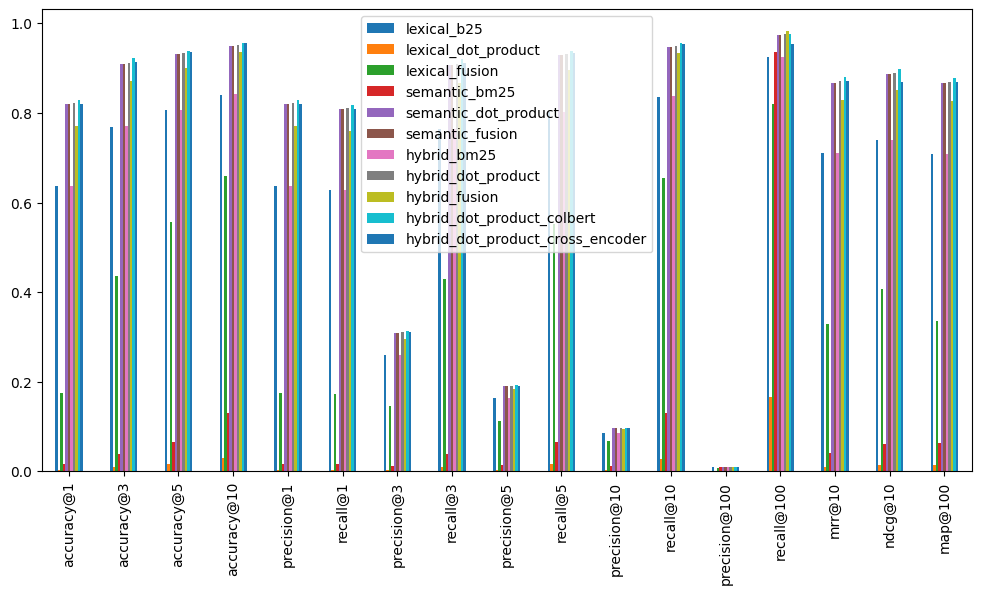

In [286]:
results.plot(kind="bar", figsize=(12, 6))

[Text(0, 0.5, 'time (ms)')]

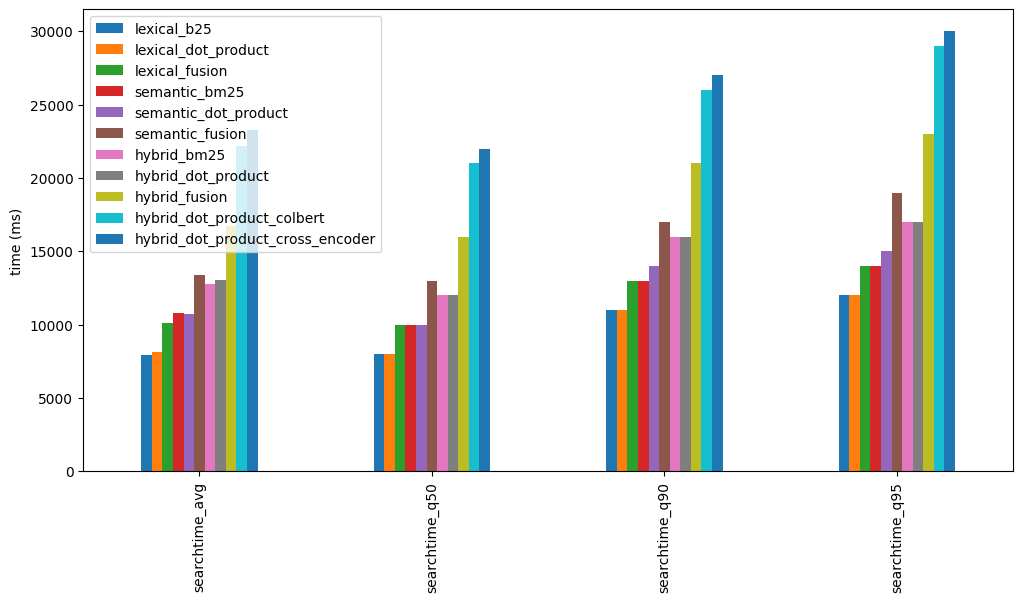

In [305]:
# plot search time, add (ms) to the y-axis
# convert to ms
searchtime = searchtime * 1000
searchtime.plot(kind="bar", figsize=(12, 6)).set(ylabel="time (ms)")

In [307]:
searchtime

lexical_b25  lexical_dot_product  lexical_fusion  \
searchtime_avg   7950.361011          8109.205776    10097.924188   
searchtime_q50   8000.000000          8000.000000    10000.000000   
searchtime_q90  11000.000000         11000.000000    13000.000000   
searchtime_q95  12000.000000         12000.000000    14000.000000   

                semantic_bm25  semantic_dot_product  semantic_fusion  \
searchtime_avg   10814.079422          10730.595668     13393.050542   
searchtime_q50   10000.000000          10000.000000     13000.000000   
searchtime_q90   13000.000000          14000.000000     17000.000000   
searchtime_q95   14000.000000          15000.000000     19000.000000   

                hybrid_bm25  hybrid_dot_product  hybrid_fusion  \
searchtime_avg  12800.99278        13018.501805   16755.866426   
searchtime_q50  12000.00000        12000.000000   16000.000000   
searchtime_q90  16000.00000        16000.000000   21000.000000   
searchtime_q95  17000.00000        17000.000000   23000.000000   

                hybrid_dot_product_colbert  hybrid_dot_product_cross_encoder  
searchtime_avg                22194.494585                         23275.134  
searchtime_q50                21000.000000                         22000.000  
searchtime_q90                26000.000000                         27000.000  
searchtime_q95                29000.000000                         30000.000

In [ ]:
vespa_cloud.delete()